In [26]:
import torch
from torch import nn
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split
from helper_functions import plot_predictions, plot_decision_boundary

In [2]:
n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state=42)

In [3]:
X.shape, y.shape

((1000, 2), (1000,))

In [4]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

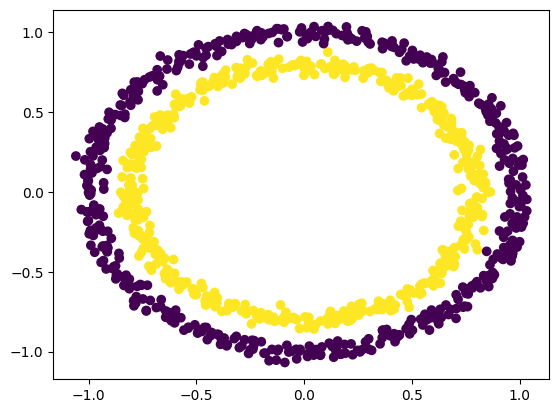

In [5]:
plt.scatter(x = X[:, 0], y= X[:, 1], c = y)

In [6]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

> Build a Model

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
class CircleModelVo(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

  def forward(self, X:torch.tensor):
    return self.layer_2(self.layer_1(X))

In [10]:
# torch.manual_seed(42)
model_0 = CircleModelVo().to(device)
model_0

CircleModelVo(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.6882, -0.2094],
                      [ 0.0748,  0.1308],
                      [ 0.3266,  0.4706],
                      [-0.4373,  0.1355],
                      [-0.3971, -0.3707]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.2245,  0.2562, -0.1071, -0.0281,  0.5789], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0549,  0.2405, -0.2911, -0.0467, -0.4391]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.0733], device='cuda:0'))])

In [12]:
untrained_preds = model_0(X_test.to(device))

print(f'Length of predictions: {untrained_preds.shape}')
print(f'Length of test target samples: {y_test.shape}')


Length of predictions: torch.Size([200, 1])
Length of test target samples: torch.Size([200])


In [13]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 1e-1)

In [14]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [15]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2368],
        [-0.1588],
        [-0.3500],
        [-0.2051],
        [-0.2049]], device='cuda:0', grad_fn=<SliceBackward0>)

In [16]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4411],
        [0.4604],
        [0.4134],
        [0.4489],
        [0.4490]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [17]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [18]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

> Building a Training Loop

In [19]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()

  with torch.inference_mode():

    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.2f} | Accuracy: {acc:.2f} | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}')

Epoch: 0 | Loss: 0.70 | Accuracy: 50.00 | Test Loss: 0.70 | Test Accuracy: 50.00
Epoch: 10 | Loss: 0.70 | Accuracy: 46.75 | Test Loss: 0.70 | Test Accuracy: 44.50
Epoch: 20 | Loss: 0.69 | Accuracy: 46.25 | Test Loss: 0.70 | Test Accuracy: 42.50
Epoch: 30 | Loss: 0.69 | Accuracy: 47.50 | Test Loss: 0.70 | Test Accuracy: 48.50
Epoch: 40 | Loss: 0.69 | Accuracy: 48.50 | Test Loss: 0.70 | Test Accuracy: 50.50
Epoch: 50 | Loss: 0.69 | Accuracy: 49.12 | Test Loss: 0.70 | Test Accuracy: 48.50
Epoch: 60 | Loss: 0.69 | Accuracy: 49.38 | Test Loss: 0.69 | Test Accuracy: 49.50
Epoch: 70 | Loss: 0.69 | Accuracy: 49.62 | Test Loss: 0.69 | Test Accuracy: 49.00
Epoch: 80 | Loss: 0.69 | Accuracy: 49.75 | Test Loss: 0.69 | Test Accuracy: 49.00
Epoch: 90 | Loss: 0.69 | Accuracy: 50.12 | Test Loss: 0.69 | Test Accuracy: 49.00


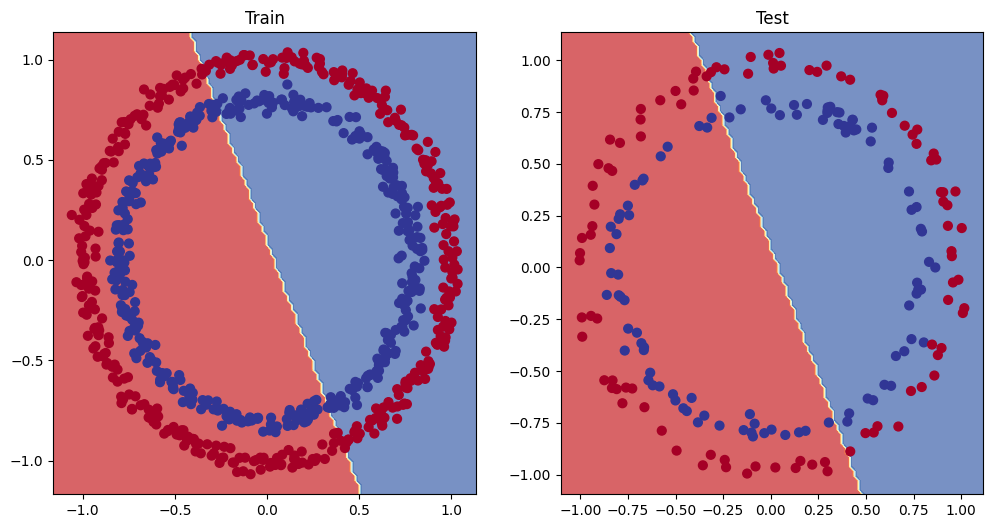

In [20]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

> Bulding a model with Non-Linearity

In [21]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, X: torch.tensor):
    X = self.relu(self.layer_1(X))
    X = self.relu(self.layer_2(X))
    X = self.layer_3(X)

    return X

model_2 = CircleModelV1().to(device)
print(model_2)


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [22]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 1e-1)

In [23]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_2.train()

  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()

  with torch.inference_mode():

    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.2f} | Accuracy: {acc:.2f} | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}')

Epoch: 0 | Loss: 0.69 | Accuracy: 50.00 | Test Loss: 0.69 | Test Accuracy: 50.00
Epoch: 100 | Loss: 0.69 | Accuracy: 52.88 | Test Loss: 0.69 | Test Accuracy: 52.50
Epoch: 200 | Loss: 0.69 | Accuracy: 53.37 | Test Loss: 0.69 | Test Accuracy: 55.00
Epoch: 300 | Loss: 0.69 | Accuracy: 53.00 | Test Loss: 0.69 | Test Accuracy: 56.00
Epoch: 400 | Loss: 0.69 | Accuracy: 52.75 | Test Loss: 0.68 | Test Accuracy: 56.50
Epoch: 500 | Loss: 0.68 | Accuracy: 52.75 | Test Loss: 0.68 | Test Accuracy: 56.50
Epoch: 600 | Loss: 0.68 | Accuracy: 54.50 | Test Loss: 0.67 | Test Accuracy: 56.00
Epoch: 700 | Loss: 0.67 | Accuracy: 58.38 | Test Loss: 0.66 | Test Accuracy: 59.00
Epoch: 800 | Loss: 0.65 | Accuracy: 64.00 | Test Loss: 0.65 | Test Accuracy: 67.50
Epoch: 900 | Loss: 0.62 | Accuracy: 74.00 | Test Loss: 0.62 | Test Accuracy: 79.00


In [24]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

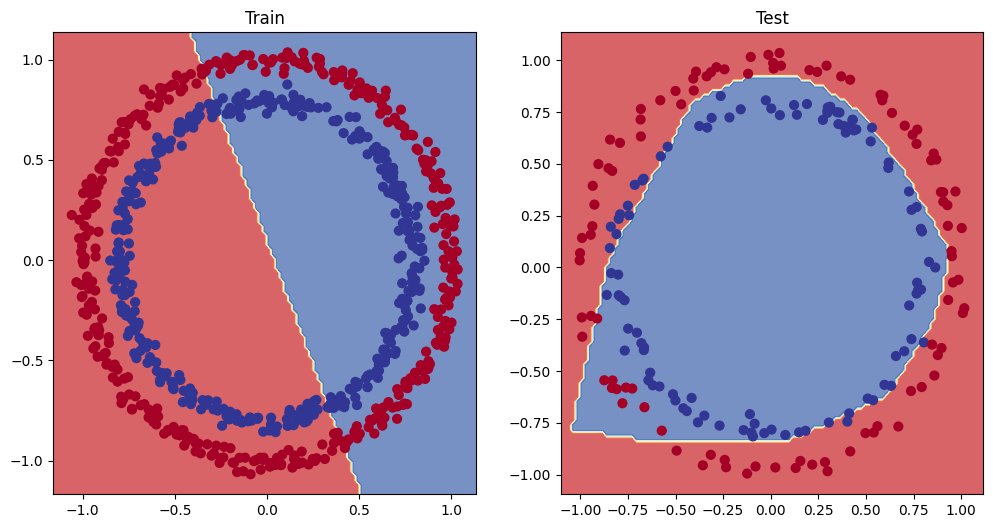

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test) # model_3 = has non-linearity

> Creating a MultiClass Clasification data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


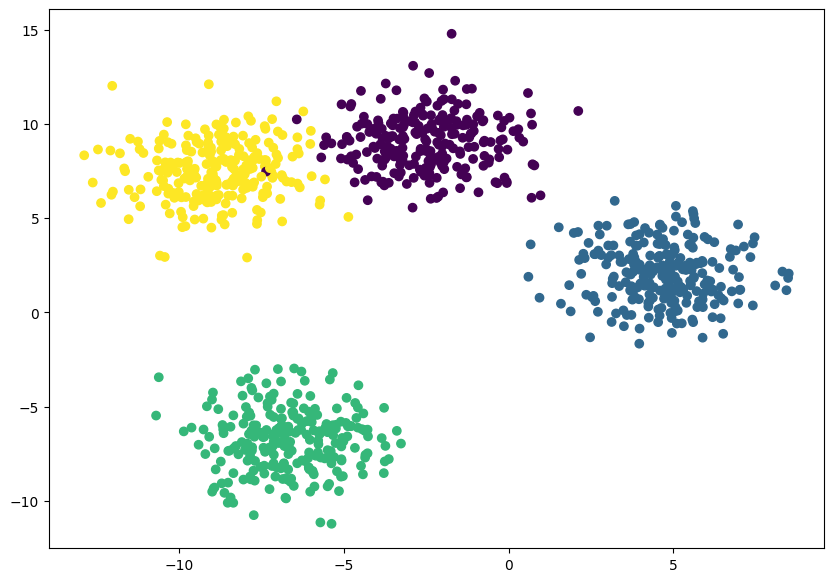

In [28]:
num_classes = 4
num_features = 2
random_seed = 42

X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features=num_features,
                            centers = num_classes,
                            cluster_std = 1.5,
                            random_state = random_seed)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size = 0.2, random_state = random_seed

)

plt.figure(figsize = (10,7))

plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob)

In [30]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.Linear(hidden_units, hidden_units),
        nn.Linear(hidden_units, output_features)
    )

  def forward(self, X: torch.tensor) -> torch.tensor:
    return self.linear_layer_stack(X)

model_4 = BlobModel(input_features = num_features,
                    output_features=num_classes).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_4.parameters(), lr = 1e-1)

In [33]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()

  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_pred)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.2f} | Accuracy: {acc:.2f} | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}')

Epoch: 0 | Loss: 1.04 | Accuracy: 65.50 | Test Loss: 0.58 | Test Accuracy: 95.50
Epoch: 10 | Loss: 0.14 | Accuracy: 99.12 | Test Loss: 0.13 | Test Accuracy: 99.00
Epoch: 20 | Loss: 0.08 | Accuracy: 99.12 | Test Loss: 0.07 | Test Accuracy: 99.50
Epoch: 30 | Loss: 0.06 | Accuracy: 99.12 | Test Loss: 0.05 | Test Accuracy: 99.50
Epoch: 40 | Loss: 0.05 | Accuracy: 99.00 | Test Loss: 0.04 | Test Accuracy: 99.50
Epoch: 50 | Loss: 0.04 | Accuracy: 99.00 | Test Loss: 0.03 | Test Accuracy: 99.50
Epoch: 60 | Loss: 0.04 | Accuracy: 99.00 | Test Loss: 0.03 | Test Accuracy: 99.50
Epoch: 70 | Loss: 0.04 | Accuracy: 99.00 | Test Loss: 0.03 | Test Accuracy: 99.50
Epoch: 80 | Loss: 0.03 | Accuracy: 99.00 | Test Loss: 0.03 | Test Accuracy: 99.50
Epoch: 90 | Loss: 0.03 | Accuracy: 99.12 | Test Loss: 0.02 | Test Accuracy: 99.50


In [37]:
model_4.eval()

with torch.inference_mode():
  y_logits = model_4(X_blob_test)

X_blob_test[:10]

tensor([[ 4.6675,  4.4878],
        [-7.9969,  6.8803],
        [-6.2801, -7.8571],
        [ 3.6833,  1.1767],
        [-0.1404, 10.1654],
        [-9.7570,  7.8658],
        [-4.4295, -8.5996],
        [-2.1731,  9.0332],
        [-9.2145, -7.5223],
        [-1.4015,  9.2713]], device='cuda:0')

In [40]:
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred = y_pred_probs.argmax(dim=1)

print(f'Predictions: {y_pred[:10]}\n Labels: {y_blob_test[:10]}')
print(f'Test Accuracy: {accuracy_fn(y_blob_test, y_pred)}')

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
 Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test Accuracy: 99.5


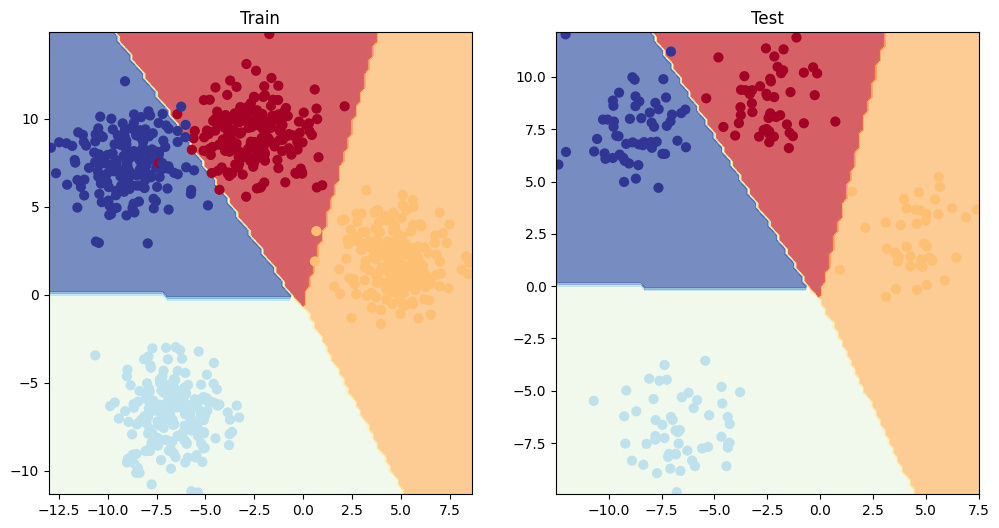

In [41]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [44]:
try:
  from torchmetrics import Accuracy
except:
  ! pip install torchmetrics
  from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task = 'multiclass', num_classes = 4).to(device)

print(f'Accuracy using torchmetrics: {torchmetrics_accuracy(y_pred, y_blob_test) * 100}')


Accuracy using torchmetrics: 99.5


In [60]:
from torchmetrics import ConfusionMatrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrix(task = 'multiclass', num_classes = 4).to(device)
cm_blob = cm(y_pred, y_blob_test)
cm_blob

tensor([[49,  0,  0,  0],
        [ 0, 41,  0,  0],
        [ 0,  0, 53,  0],
        [ 1,  0,  0, 56]], device='cuda:0')

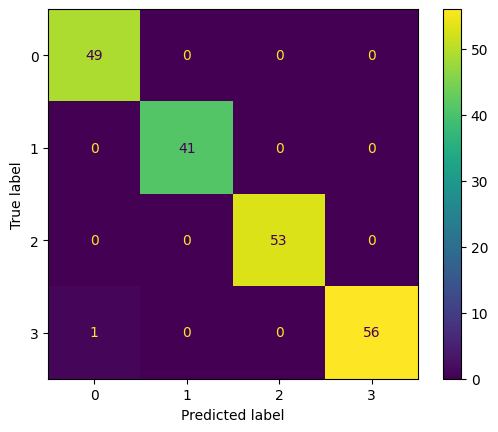

In [64]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm_blob.cpu().numpy(), display_labels = range(num_classes))
disp.plot()
plt.show()

In [73]:
from sklearn.metrics import classification_report

class_report = classification_report(y_blob_test.cpu().numpy(), y_pred.cpu().numpy(), labels = range(num_classes))
print(class_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        53
           3       1.00      0.98      0.99        57

    accuracy                           0.99       200
   macro avg       0.99      1.00      1.00       200
weighted avg       1.00      0.99      1.00       200

